# Instacart Customer Value - Exploratory Analysis

## 1. Executive Summary

Customer value is strongly associated with order frequency, basket size, and reorder rate. However, customer behavior is highly heterogeneous, so segmentation and tailored strategies will be more effective than a one-size-fits-all approach

## 2. Plan, Scope and Context

| Question | Business Objective | Why It Matters |
| :--- | :--- | :--- |
| **(1) How do we define customer value?** | To establish a clear, quantifiable metric for customer value based on purchasing behavior | Provides a basis for analysing value related behvaiour (comparisons, segmentation) |
| **(2) What are the relationships between customer value and reordered product proportion, frequency, and basket size?** | Provide a high level view on how factors like reorder rate, order frequency vary with customer value | Provide high level customer behaviour insights which may inform marketing and loyalty programs, serves as a basis for predictive analysis and customer segmentation to further develop strategy |

### Future Opportunities
This foundation can enable further analyses for more advanced insights:
* Regression: Explore the interaction effects and explanatory power of our key behavioral metrics on customer value.
* Segmentation: Use our customer value metric, along with demographic and spend data, to build actionable customer segments. This will enable tailored marketing strategies and service offerings.
* Cohort-based analyses: Examine how ordering behavior and customer value evolve over time to better understand customer engagement and loyalty.

### Measurement

* **Average monthly value:** We will construct a proxy for value by calculating total products using the number of products included in each order and the `days_since_prior_order` data.
* **Reorder Rate:** The reordered flag will be used to calculate the proportion of reordered items per customer.
* **Order Frequency:** The days_since_prior_order and the ordinality of each order will be used to calculate a user's average orders per month.
* **Basket Size:** The number of items per order will be used to calculate the average items per basket for each customer.

## 3. Data understanding, cleaning, validation

**Dataset:** Instacart Online Grocery Shopping Dataset 2017  
**Source:** https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset                  
**Description:** Contains anonymised transactional data from over 3 million grocery orders by ~200,000 users in the US.  
**Limitations:** Data from 2017; no price or revenue information; No unit numbers (limited granularity); anonymised IDs prevent demographic analysis


### Imports and Data Download

In [22]:
# Import necessary libraries for data analysis and visualization.
# - kagglehub: For downloading the dataset from Kaggle.
# - pandas: For data manipulation and analysis in DataFrame format.
# - numpy: For numerical operations, especially with arrays.
# - os: For interacting with the operating system, like file paths.
# - matplotlib.pyplot and seaborn: For creating plots and data visualizations.
# - duckdb: For efficient in-memory data processing via SQL.
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

# Connect to a DuckDB database file. This will either connect to an existing
# database or create a new one named 'instacart.duckdb' in the current
# directory. This serves as the primary data storage and processing engine.
con = duckdb.connect("instacart.duckdb")

# Download the Instacart dataset from KaggleHub. The returned 'path' variable points to the local directory
# where the dataset files (e.g., CSVs) are stored.
path = kagglehub.dataset_download("yasserh/instacart-online-grocery-basket-analysis-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\jbara\.cache\kagglehub\datasets\yasserh\instacart-online-grocery-basket-analysis-dataset\versions\1


### Configuration

In [23]:
# Define file paths.
orders_path = os.path.join(path, 'orders.csv')
prior_path = os.path.join(path, 'order_products__prior.csv')
train_path = os.path.join(path, 'order_products__train.csv')
aisles_path = os.path.join(path, 'aisles.csv')
departments_path = os.path.join(path, 'departments.csv')
products_path = os.path.join(path, 'products.csv')

# Define paths for project files
project_root = os.getcwd()
data_path = os.path.join(project_root, 'data')
sql_dir = os.path.join(project_root, 'sql')

### Data preparation

#### Data types

Initial data exploration revealed that due to SQLite's flexible typing, all columns were imported as TEXT, even those containing numerical data. This was confirmed by using the typeof() function for each table, e.g.:

```SQL
SELECT typeof(product_id), COUNT(*)
FROM products
GROUP BY typeof(product_id);
```

Investigation also revealed Nulls were cast as empty strings. The data is therefore cast into the appropriate data types:

In [24]:
# Load data into DuckDB for efficient querying

# Register clean table names as filepaths so we can keep SQL generic
# Register core Instacart datasets with DuckDB (so the CSV's are now tables in DuckDB we can refer to)
# Using TRYCAST to replace empty strings with integers or floats for numeric cols

#--- 1. Orders ---
con.execute(f"""
CREATE OR REPLACE TABLE orders_raw AS
SELECT * 
FROM read_csv_auto('{orders_path}', all_varchar=True)
""")

con.execute("""
CREATE OR REPLACE TABLE orders AS
SELECT *,
       TRY_CAST(NULLIF(user_id, '') AS INTEGER) AS user_id_clean,
       TRY_CAST(NULLIF(days_since_prior_order, '') AS DOUBLE) AS days_since_prior_order_clean
FROM orders_raw
""")

#--- 2. Order products prior ---
con.execute(f"""
CREATE OR REPLACE TABLE order_products_prior_raw AS
SELECT * 
FROM read_csv_auto('{prior_path}', all_varchar=True)
""")

con.execute("""
CREATE OR REPLACE TABLE order_products_prior AS
SELECT *,
       TRY_CAST(NULLIF(order_id, '') AS INTEGER) AS order_id_clean,
       TRY_CAST(NULLIF(product_id, '') AS INTEGER) AS product_id_clean,
       TRY_CAST(NULLIF(reordered, '') AS INTEGER) AS reordered_clean
FROM order_products_prior_raw
""")

#--- 3. Order products train ---
con.execute(f"""
CREATE OR REPLACE TABLE order_products_train_raw AS
SELECT * 
FROM read_csv_auto('{train_path}', all_varchar=True)
""")

con.execute("""
CREATE OR REPLACE TABLE order_products_train AS
SELECT *,
       TRY_CAST(NULLIF(order_id, '') AS INTEGER) AS order_id_clean,
       TRY_CAST(NULLIF(product_id, '') AS INTEGER) AS product_id_clean,
       TRY_CAST(NULLIF(reordered, '') AS INTEGER) AS reordered_clean
FROM order_products_train_raw
""")

#--- 4. Products ---
con.execute(f"""
CREATE OR REPLACE TABLE products_raw AS
SELECT * 
FROM read_csv_auto('{products_path}', all_varchar=True)
""")

con.execute("""
CREATE OR REPLACE TABLE products AS
SELECT *,
       TRY_CAST(NULLIF(product_id, '') AS INTEGER) AS product_id_clean,
       TRY_CAST(NULLIF(department_id, '') AS INTEGER) AS department_id_clean
FROM products_raw
""")

#--- 5. Departments ---
con.execute(f"""
CREATE OR REPLACE TABLE departments_raw AS
SELECT * 
FROM read_csv_auto('{departments_path}', all_varchar=True)
""")

con.execute("""
CREATE OR REPLACE TABLE departments AS
SELECT *,
       TRY_CAST(NULLIF(department_id, '') AS INTEGER) AS department_id_clean
FROM departments_raw
""")

#--- 6. Aisles ---
con.execute(f"""
CREATE OR REPLACE TABLE aisles_raw AS
SELECT * 
FROM read_csv_auto('{aisles_path}', all_varchar=True)
""")

con.execute("""
CREATE OR REPLACE TABLE aisles AS
SELECT *,
       TRY_CAST(NULLIF(aisle_id, '') AS INTEGER) AS aisle_id_clean
FROM aisles_raw
""")

### Data validation

### Orders

#### order_dow

We assumed that this is the day of the week the order was placed. To examine this and the indexing method, ran a query to display counts for each value:

```SQL
SELECT
  order_dow,
  COUNT(order_dow)
FROM
  orders
GROUP BY
  order_dow
ORDER BY
  order_dow;
```

Findings: Index runs from 0-6, highest order counts at 0 and 1 possibly indicating weekend.

#### order_number

We assumed that this is the sequential order number for each user To examine this we ran a query to display the order numbers for each user, in order. We expected to see a continuous sequence. 

```SQL
SELECT
  user_id,
  order_number
FROM
  orders
ORDER BY
  user_id,
  order_number
```
Findings: We saw a continuous sequence of order numbers for each user.

### order_products_prior / order_products_train

#### add_to_cart_order

We assumed that this is the sequential order in which a product was added to the cart, for an order. To examine this we ran a query to display the add to cart order for each order, in order. We expected to see a continuous sequence. 

```SQL
SELECT
  order_id,
  add_to_cart_order
FROM
  order_products__prior
ORDER BY
  order_id,
  add_to_cart_order
```
Findings: We saw a continuous sequence of add to cart order for each order id.

### Data Dictionary

#### Table: `orders`

| Column Name | Data Type | Description | Example row |
| :--- | :--- | :--- | :--- |
| `order_id` | string (cast to integer) | Unique numeric id for each order. Primary key for this table. | `123456` |
| `user_id` | string (cast to integer) | Numeric id for the user. | `123` |
| `eval_set` | string | Indicates whether the order is part of the prior or train set. | `'prior'` |
| `order_number` | string (cast to integer) | Numeric sequential order number for the user. | `4` |
| `order_dow` | string (cast to integer) | Numeric indicator of day of week, starting at 0 Saturday. | `3` |
| `order_hour_of_day` | string (cast to integer) | Hour of day the order was placed (0-23). | `10` |
| `days_since_prior_order` | string (cast to integer) | Null value indicates the user's first order. | `30` or `Null` |

---

#### Table: `products`

| Column Name | Data Type | Description | Example row |
| :--- | :--- | :--- | :--- |
| `product_id` | string (cast to integer) | Primary key for this table. | `1234` |
| `product_name` | string | Name of the product. | `'Organic Strawberries'` |
| `aisle_id` | string (cast to integer) | Foreign key to the `aisles` table. | `24` |
| `department_id` | string (cast to integer) | Foreign key to the `departments` table. | `4` |

---

#### Table: `aisles`

| Column Name | Data Type | Description | Example row |
| :--- | :--- | :--- | :--- |
| `aisle_id` | string (cast to integer) | Numeric id for the aisle. Primary key for this table. | `24` |
| `aisle` | string | String aisle name. | `'fresh fruits'` |

---

#### Table: `departments`

| Column Name | Data Type | Description | Example row |
| :--- | :--- | :--- | :--- |
| `department_id` | string (cast to integer) | Numeric id for department. Primary key for this table. | `4` |
| `department` | string | String department name. | `'produce'` |

---

#### Table: `order_products__prior`

| Column Name | Data Type | Description | Example row |
| :--- | :--- | :--- | :--- |
| `order_id` | string (cast to integer) | Foreign key to the `orders` table. | `123456` |
| `product_id` | string (cast to integer) | Numeric product id. Foreign key to the `products` table. | `1234` |
| `add_to_cart_order` | string (cast to integer) | Order in which product was added to cart. | `1` |
| `reordered` | string (cast to integer) | A binary flag (0 or 1) indicating if a product was previously purchased by the user. | `1` |

---

#### Table: `order_products__train`

| Column Name | Data Type | Description | Example row |
| :--- | :--- | :--- | :--- |
| `order_id` | string (cast to integer) | Foreign key to the `orders` table. | `123456` |
| `product_id` | string (cast to integer) | Foreign key to the `products` table. | `1234` |
| `add_to_cart_order` | string (cast to integer) | Order in which product was added to cart. | `1` |
| `reordered` | string (cast to integer) | A binary flag (0 or 1) indicating if a product was previously purchased by the user. | `1` |

---

#### Key Relationships

The following relationships are crucial for joining the tables:

* `orders` joins to `order_products__prior` on `order_id`.
* `products` joins to `order_products__prior` on `product_id`.
* `products` joins to `aisles` on `aisle_id`.
* `products` joins to `departments` on `department_id`.

### Initial checks

#### Row and columns counts:

To ensure the dataset's integrity, we performed an initial check of row and column counts for each table. The actual counts, derived from our SQL queries, are compared against the documented figures from the Kaggle dataset page.

We used PRAGMA table_info() to identify column counts, and COUNT to identify row counts:

```SQL
PRAGMA table_info(table_name)
```

#### Primary key duplicates:

We grouped by the primary key(s) and used COUNT, filtering for counts over 1 to identify any primary key duplicates:

```SQL
SELECT
  order_id,
  COUNT(order_id) AS duplicate_count
FROM
  orders
GROUP BY
  order_id
HAVING
  duplicate_count > 1;
```

#### Full row duplicates:

We grouped by all columns in each table, and used COUNT, filtering for counts over 1 to identify any full row duplicates:

```SQL
SELECT
  column1,
  column2,
  column3,
  COUNT(*) as duplicate_count
FROM
  your_table
GROUP BY
  column1,
  column2,
  column3
HAVING
  duplicate_count > 1;
```

#### Missing values

We use a conditional aggregation to check for nulls in each column:

```SQL

SELECT
  COUNT(CASE WHEN column_name IS NULL THEN 1 ELSE NULL) AS column_name_nulls
FROM
  table_name
```

This revealed no Null's for all but the `days_since_prior_order` column of 'orders'. Handling of these missing values is discussed in data cleaning, here is a table of findings for initial checks:

| Table Name | Rows (Actual) | Columns (Actual) | Rows (Kaggle Doc - approx.) | Columns (Kaggle Doc) | Primary Key | PK Duplicates | Row Duplicates | Missing Values |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| `orders` | 3421083 | 7 | 3420000 | 7 | order_id | None | None | days_since_prior_order: 206209, 6% |
| `products` | 49688 | 4 | 49700 | 4 | product_id | None | None | None |
| `aisles` | 134 | 2 | 134 | 2 | aisle_id | None | None | None |
| `departments` | 21 | 2 | 21 | 2 | Department_id | None | None | None |
| `order_products__prior` | 32434489 | 4 | 3420000 | 4 | order_id, product_id | None | None | None |
| `order_products__train` | 1384617 | 4 | 1380000 | 4 | order_id, product_id | None | None | None |

#### Santity checks

**Check `order_products_prior` and -> `orders` foreign key integrity**

```SQL
SELECT COUNT(*) AS missing_orders
FROM order_products__prior op
LEFT JOIN orders o ON op.order_id = o.order_id
WHERE o.order_id IS NULL;
```

Returns 0, so no orders in `order_products_prior` with order_id's that are missing from `orders`. 

**Check `order_products__prior` -> `products` foreign key integrity**

```SQL
SELECT COUNT(*) AS missing_products
FROM order_products__prior op
LEFT JOIN products p
  ON op.product_id = p.product_id
WHERE p.product_id IS NULL;
```
Returns 0, so no orders in `order_products_prior` with product_id's that are missing from `orders`. 

**Coverage check – departments used in `products`**

```SQL
SELECT COUNT(DISTINCT department_id) AS depts_in_products
FROM products;
```

Returns 21, which matches the number of department rows in `departments`. 

**Distribution check – `days_since_prior_order`**

```SQL
SELECT
  days_since_prior_order,
  COUNT(order_id)
FROM
  orders
GROUP BY
  days_since_prior_order
ORDER BY
  days_since_prior_order;
  ```

|days_since_prior_order|COUNT(order_id)|
|----------------------|---------------|
||206209|
|0.0|67755|
|1.0|145247|
|2.0|193206|
|3.0|217005|
|4.0|221696|
|5.0|214503|
|6.0|240013|
|7.0|320608|
|8.0|181717|
|9.0|118188|
|10.0|95186|
|11.0|80970|
|12.0|76146|
|13.0|83214|
|14.0|100230|
|15.0|66579|
|16.0|46941|
|17.0|39245|
|18.0|35881|
|19.0|34384|
|20.0|38527|
|21.0|45470|
|22.0|32012|
|23.0|23885|
|24.0|20712|
|25.0|19234|
|26.0|19016|
|27.0|22013|
|28.0|26777|
|29.0|19191|
|30.0|369323|

The days since prior order data ranges from Null, through to 0 to 30. We hypothesise that the missing data from `days_since_prior_order` reflects a first order. Visual inspection indicates these missing data align with `order_number` 1, supporting this hypothesis. A query is used to confirm they all correspond to `order_number` 1:

```SQL
SELECT days_since_prior_order, 
       order_number
  FROM orders
WHERE order_number != 1 AND  days_since_prior_order = NULL
```

No results are returned, confirming all NULLs correspond to `order_number` of 1. 

There is a significant peak at 30 (the mode), we assume therefore that this represents not 30 days exactly, but 30+ days since prior order. A limitation of the data is that we cannot analyse gaps > 30 days to improve the precision of frequency measurement and analysis. A further limitation is that we are not given time since last order, preventing a precise tenure estimate.

**Distribution check – number of orders per user**

```SQL
WITH counting_orders AS (
	SELECT
	  COUNT(order_number) as number_of_orders
	FROM
	  orders
	GROUP BY
	  user_id
	 ) 
SELECT number_of_orders,
		COUNT(number_of_orders) as frequency
  FROM 
      counting_orders
  GROUP BY number_of_orders
  ORDER BY number_of_orders
```

The number of orders ranges from 4 to 100. There is a peak of users who have placed 4 orders, which then decreases mostly monotonically, before increasing from 47 users who placed 99 orders, to 1374 who placed 100. This suggests the 100 orders category includes 100 orders or more.

## 4. Analysis


### 4.1. How do we define customer value?

Data limitations: 
 - We do not have access to spend or unit data, only products included in each order. This limits the precision of our value estimate significantly. We will proceed using product count as a rough proxy, ackowledging that noise may limit interpretation of results (and our 'value' estimate could also be interpreted as product diversity).
 - We do not have access to customer tenure data, to normalize the product count and produce value/time. We will therefore proceed using the sum of days since prior order as a proxy for tenure. This data does not indicate when the last order occurred relative to the data being pulled, so it's possible some have not ordered for some time since the data was pulled, limiting the precision of the tenure and therefore value estimate.


We will calculate the customer value by summing the number of products, and diving by the total days since prior order. Cusomers with a sum of 0 (single day of orders, or single order only) will be excluded as it is not possible to calculate a value/time rate without a tenure estimate. 

In [25]:
# ---Calculating customer monthly value---
customer_value = con.execute("""
WITH user_orders_cleaned AS (
    -- This CTE cleans and prepares the data from the 'orders' table.
    -- It ensures 'user_id' is an integer and handles potential empty strings
    -- in 'days_since_prior_order' by casting them to a float and treating
    -- empty values as 0.0.
    SELECT
        user_id_clean,
        order_id,
        CASE
            WHEN days_since_prior_order IS NOT NULL THEN CAST(days_since_prior_order AS FLOAT)
            ELSE 0.0
        END AS days_since_prior_order_clean,
        order_number
    FROM orders
),

total_days_orders AS (
    -- This CTE calculates the total days between orders and the total number
    -- of orders for each user.
    SELECT
        user_id_clean AS user_id,
        SUM(days_since_prior_order_clean) AS total_days,
        COUNT(order_id) AS total_orders
    FROM user_orders_cleaned
    GROUP BY user_id_clean
),

products_joined AS (
    -- This CTE combines product information from two tables
    SELECT order_id, product_id, reordered_clean
    FROM "order_products_prior"
    UNION ALL
    SELECT order_id, product_id, reordered_clean
    FROM "order_products_train"
),

products_by_user AS (
    -- This CTE aggregates product-related metrics for each user, including
    -- total products, reordered products, and total orders.
    SELECT
        o.user_id_clean AS user_id,
        COUNT(pj.product_id) AS total_products,
        SUM(pj.reordered_clean) AS reordered_products,
        COUNT(DISTINCT o.order_id) AS total_orders
    FROM user_orders_cleaned AS o
    JOIN products_joined AS pj
    ON o.order_id = pj.order_id
    GROUP BY o.user_id_clean
),

user_value AS (
    -- This CTE calculates a "daily value" metric for each user.
    -- The `ANY_VALUE()` function is used to so that total_products and 
    -- total_days are included in an agg function, as they are not in the group by clause
    -- and they must be in the group by clause or aggregated to satisfy SQL syntax
    SELECT
        pbu.user_id,
        30.417 * ((ANY_VALUE(pbu.total_products) * 1.0) / ANY_VALUE(tdo.total_days)) AS avg_monthly_value
    FROM products_by_user AS pbu
    JOIN total_days_orders AS tdo
    ON pbu.user_id = tdo.user_id
    WHERE tdo.total_days != 0
    GROUP BY pbu.user_id
)

SELECT *
FROM user_value;""").df()
customer_value

,user_id,avg_monthly_value
0,111921,90.640917
1,153823,30.533095
2,79744,25.049294
3,161466,28.750315
4,93171,119.996736
...,...,...
206198,150504,17.916863
206199,100255,5.833397
206200,111970,9.698174
206201,126514,31.124372


Descriptive Statistics for Average Monthly Value

In [26]:
print(customer_value['avg_monthly_value'].describe())

count    206203.000000
mean         27.631879
std          25.929950
min           1.013900
25%          12.133090
50%          20.842847
75%          34.901558
max        1388.318786
Name: avg_monthly_value, dtype: float64


Distribution of Average Monthly Value

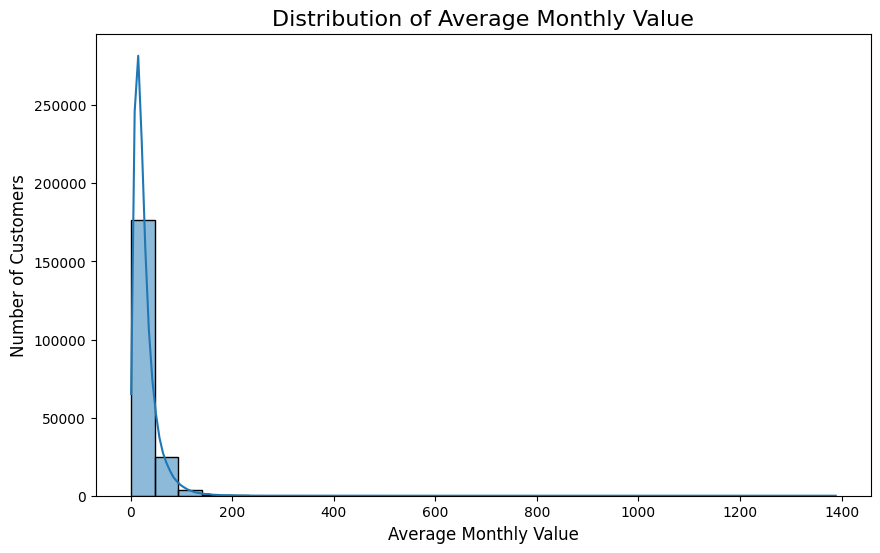

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=customer_value, x='avg_monthly_value', bins=30, kde=True)
plt.title('Distribution of Average Monthly Value', fontsize=16)
plt.xlabel('Average Monthly Value', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.show()

We see from the quartiles that the majority of the data is compressed at the lower end of the distribution. For instance, the first 75% of customers are concentrated in the first third of the value range. We will explore a full range of percentiles to better understand the true shape of this right-skewed distribution and where the majority of the data truly lies.

In [28]:
# Display all rows to inspect the full range of percentiles.
pd.set_option('display.max_rows', None)

percentiles = list(np.arange(0, 1, 0.01))
print(customer_value['avg_monthly_value'].quantile(percentiles))

# Revert to default display settings to keep the notebook clean
pd.set_option('display.max_rows', 20)

0.00      1.013900
0.01      2.339769
0.02      2.982059
0.03      3.548650
0.04      4.055600
0.05      4.530191
0.06      5.000055
0.07      5.443042
0.08      5.869947
0.09      6.306271
0.10      6.726837
0.11      7.124703
0.12      7.518809
0.13      7.908420
0.14      8.295545
0.15      8.690571
0.16      9.042892
0.17      9.395827
0.18      9.749038
0.19     10.139000
0.20     10.450969
0.21     10.784209
0.22     11.134795
0.23     11.468705
0.24     11.794347
0.25     12.133090
0.26     12.456486
0.27     12.781612
0.28     13.106512
0.29     13.430001
0.30     13.760071
0.31     14.095683
0.32     14.408053
0.33     14.740546
0.34     15.074967
0.35     15.408612
0.36     15.747809
0.37     16.091574
0.38     16.441622
0.39     16.781793
0.40     17.109563
0.41     17.473596
0.42     17.815671
0.43     18.180276
0.44     18.554370
0.45     18.933031
0.46     19.303096
0.47     19.681588
0.48     20.062277
0.49     20.452810
0.50     20.842847
0.51     21.262369
0.52     21.

The distribution of average monthly value is highly right-skewed, with a long tail of high-value customers. The vast majority of our customers are concentrated at the lower end of the value spectrum.

Specifically, the 99th percentile is at 118.05 products per month. This means that 99% of all customers have an average monthly value of less than 118.05. The top 1% of customers exhibit a dramatically different purchasing behavior, making their distribution difficult to compare with the rest of the customer base.

To gain a clearer understanding of the majority of our customers, we will analyze and visualize the data for the bottom 99% separately. We will also perform a dedicated analysis on this top 1% of high-value customers to uncover unique insights into their purchasing habits and potential drivers of their high value.

In [29]:
customer_value_trunc = customer_value[customer_value['avg_monthly_value'] <= 118.046245]

We can now visualize the truncated data to explore it's distribution:

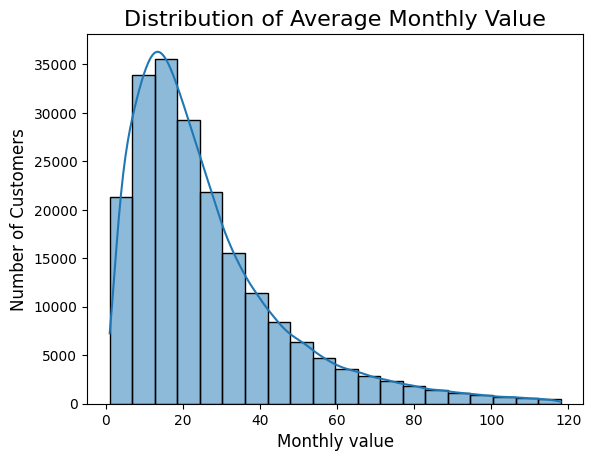

In [30]:
plt.plot(figsize=(10,6))
sns.histplot(data=customer_value_trunc, x='avg_monthly_value', bins=20, kde=True)
plt.title('Distribution of Average Monthly Value', fontsize=16)
plt.xlabel('Monthly value', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.show()

 Based on the distribution of average monthly value, we observe a highly right-skewed distribution. The customer base is heavily concentrated at the lower end of the value spectrum, with a sharp peak around **12-15 products per month**. The majority of customers fall below this value, while a long tail of high-value customers extends up to 120+ products per month. This indicates that a small proportion of customers drive a significant amount of the overall value.

Our initial data profiling reveals that the median customer value is approximately **21 products/month**, with the middle 50% of customers (the interquartile range) falling between **~12 and ~35 products/month**.

To understand the key drivers of customer value, we will now explore the relationships between customer value and the following metrics:
-   **Reorder Rate:** We hypothesize a **strong positive correlation** between reorder rate and average monthly value. A higher reorder rate indicates habitual, loyal customers, who are expected to contribute a larger share of their grocery spend to Instacart.
-   **Order Frequency (orders per month):** We anticipate a **strong positive correlation** with customer value. Since monthly value is calculated using products per month, higher-frequency customers directly contribute to the numerator of this metric.
-   **Average Basket Size (items per order):** We expect a **positive correlation** between basket size and customer value, as larger baskets directly increase the number of products purchased. However, we acknowledge that this relationship may be moderated by differing purchasing habits, such as a large, one-time order versus smaller, more frequent orders. We will investigate whether this relationship holds across different user segments.

## 4.2 Main findings: Correlates of value

### What are the relationships between customer value and reordered product proportion, frequency, and basket size?

### 4.2.1 Construct metrics

We first use SQL to query re-order rate, frequency and basket size:

In [31]:
metrics = con.execute("""
WITH user_orders_cleaned AS (
    SELECT CAST(user_id AS INTEGER) AS user_id,
           order_id,
           order_number,
           CAST(NULLIF(days_since_prior_order, '') AS DOUBLE) AS days_since_prior_order
    FROM orders
),
total_days_orders AS (
    SELECT
        user_id,
        SUM(COALESCE(days_since_prior_order,0)) AS total_days,
        COUNT(order_id) AS total_orders
    FROM user_orders_cleaned
    GROUP BY user_id
),
products_joined AS (
    SELECT order_id, product_id, reordered_clean
    FROM order_products_prior
    UNION ALL
    SELECT order_id, product_id, reordered_clean
    FROM order_products_train
),
user_products AS (
    SELECT
        o.user_id,
        COUNT(pj.product_id) AS total_products,
        SUM(CASE WHEN pj.reordered_clean = 1 THEN 1 ELSE 0 END) AS reordered_products,
        COUNT(DISTINCT o.order_id) AS distinct_orders
    FROM user_orders_cleaned o
    JOIN products_joined pj ON o.order_id = pj.order_id
    GROUP BY o.user_id
)
SELECT
    up.user_id,
    -- Reorder rate
    reordered_products * 1.0 / NULLIF(total_products,0) AS reorder_rate,
    -- Frequency: orders per month
    (tdo.total_orders * 30.4167) / NULLIF(tdo.total_days,0) AS orders_per_month,
    -- Basket size
    total_products * 1.0 / NULLIF(distinct_orders,0) AS avg_basket_size,
    --- Total orders
    tdo.total_orders AS total_orders
FROM user_products up
JOIN total_days_orders tdo ON up.user_id = tdo.user_id
WHERE tdo.total_days > 0;"""
).df()
metrics

,user_id,reorder_rate,orders_per_month,avg_basket_size,total_orders
0,182785,0.705607,2.872688,12.588235,17
1,8224,0.597430,2.967483,16.678571,28
2,44706,0.766376,3.426057,22.341463,41
3,128129,0.562500,2.452960,4.000000,20
4,187213,0.500000,3.745340,5.818182,33
...,...,...,...,...,...
206198,49489,0.045455,1.502059,7.333333,4
206199,75351,0.355140,1.713617,26.750000,4
206200,45210,0.294118,1.644146,8.500000,4
206201,56572,0.714286,1.351853,1.750000,4


We now merge these metrics with our value metric, for the truncated 99% of our data, and calculate correlations:

In [32]:
metrics_trunc = (customer_value_trunc.merge(metrics, on="user_id", how="inner"))
metrics_trunc.corr(numeric_only=True)["avg_monthly_value"]

user_id             -0.002663
avg_monthly_value    1.000000
reorder_rate         0.338112
orders_per_month     0.611153
avg_basket_size      0.641853
total_orders         0.445434
Name: avg_monthly_value, dtype: float64

### 4.2.2 Reorder rates x average monthly value:

We plot reorder rates against average monthly value, with a regression line:

Pearson Correlation Coefficient: 0.34


<Axes: xlabel='avg_monthly_value', ylabel='reorder_rate'>

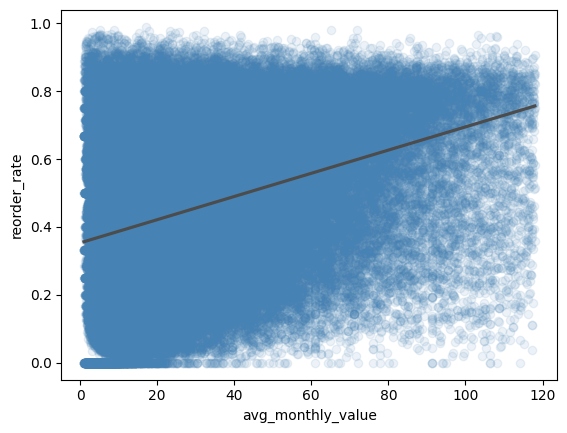

In [33]:
# Calculate and print the Pearson correlation coefficient to quantify the relationship.
correlation = metrics_trunc['avg_monthly_value'].corr(metrics_trunc['reorder_rate'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

sns.regplot(
    x="avg_monthly_value",
    y="reorder_rate",
    data=metrics_trunc,
    scatter_kws={'alpha': 0.1, 'color': 'steelblue'},
    line_kws={'color': '#4C4C4C'} 
)

There is a weak positive correlation between monthly value and reorder rate of 0.34, but the density and variability makes the relationship difficult to discern, so we employ a hexbin plot (heatmap):

<Axes: xlabel='avg_monthly_value', ylabel='reorder_rate'>

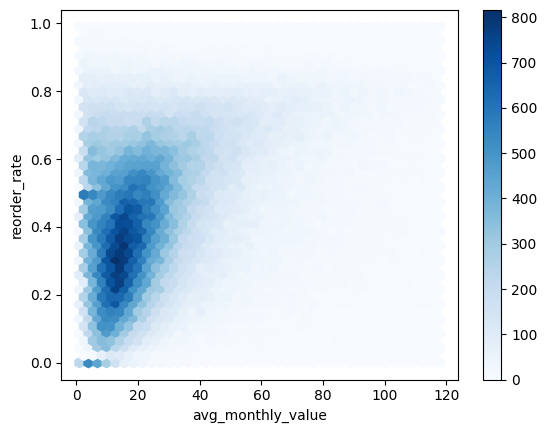

In [34]:
metrics_trunc.plot.hexbin(
    x="avg_monthly_value",
    y="reorder_rate",
    gridsize=40,
    cmap="Blues"
)

The hexbin plot shows the relationship more clearly. There is a positive correlation between re-order rate and average monthly value. The distribution of re-order rates varies greatly amongst similar value customers, but as monthly value increases, this range of reorder rates tends to reduce such that lower reorder rates are less prevalent - creating the triangular shape in the plot. This indicates higher value customers tend to have higher re-order rates (though they still vary greatly). 

We also note a cluster with a low monthly value, and re-order rate of 0, possibly reflecting early users, or churned one off users, which may be important for future analysis to encourage retention.

The density is highest for customers with value of approximately 10-20 products/month, relfecting the prevalence of these customers. Within this group, reorder rates vary significantly, leading to the vertical spread of coloured hexes observed. 

#### Observed relationship

There is a weak positive correlation between reorder rate and average monthly value (r = 0.34). The distribution takes on a triangular shape: at low values, reorder rates range widely between 0–1, but as value increases, rates converge toward ~0.8. The heatmap highlights that most customers fall within reorder rates of 0.2–0.6 and values between 0–30. A distinct cluster of low-value customers with a reorder rate of 0 likely reflects one-off or very new users, which may be strategically important for retention analysis.

#### Interpetation

The positive correlation suggests that higher reorder rates are generally associated with higher value, and that higher value is generally associated with repeated, habitual use of the service. However, the correlation is weak, and there is significant heteogeneity, indicating:
- Some high value customers have very low re-order rates, ordering a high number of new products
- Some low value customers have very high reorder rates (ordering few items, more than once)

This variation points to different customer behaviour patterns e.g. habitual re-orderers, variety seekers. Marketing strategies would benefit from segment-specific approaches, such as loyalty rewards for repeaters and targeted campaigns for variety-seekers.

#### Limitations:

Both plots have weaknesses, the scatterplots crowding makes it dififcult to discern where the majority of the data lies, and the conentration of data in the heatmap washes out other value. More critically, the absence of spend and demographic data limits interpretation. For example, a low reorder rate could reflect either high-value exploratory shopping or disengagement, which are very different in business terms (but not differentiable without household size and/or time series). Time-series analysis would also be essential to distinguish between new users with naturally low reorder rates and long-term churn risks.

#### Order frequency x monthly value

Anticipating heterogeneity and large numbers of datapoints, we employ a heatmap in addition to a scatterplot:

Pearson Correlation Coefficient: 0.61


<Axes: xlabel='avg_monthly_value', ylabel='orders_per_month'>

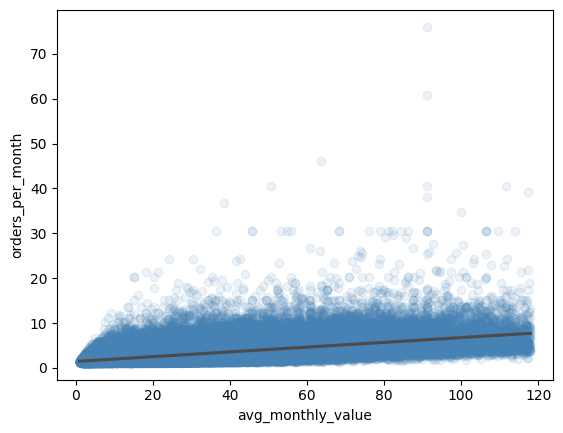

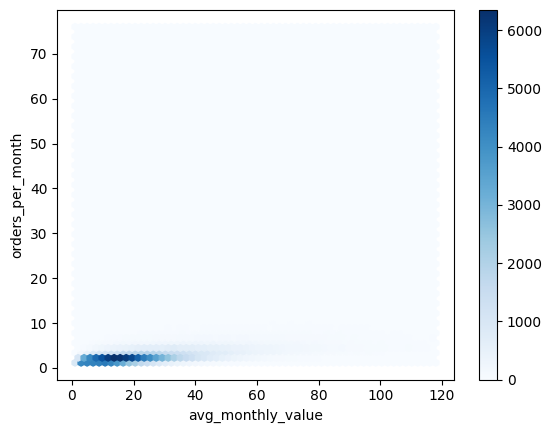

In [35]:
correlation = metrics_trunc['avg_monthly_value'].corr(metrics_trunc['orders_per_month'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

sns.regplot(
    x="avg_monthly_value",
    y="orders_per_month",
    data=metrics_trunc,
    scatter_kws={'alpha': 0.1, 'color': 'steelblue'},
    line_kws={'color': '#4C4C4C'} 
)
metrics_trunc.plot.hexbin(
    x="avg_monthly_value",
    y="orders_per_month",
    gridsize=60,
    cmap="Blues"
)


#### Observed relationships

Order frequency is strongly correlated with average monthly value (r = 0.61). The heatmap shows that most customers place between 1–4 orders per month. At lower value levels, customers appear across this full frequency range. As value increases, however, customers concentrate at the higher end of this range, with high-value customers rarely placing fewer than two orders per month.

#### Interpretation

The positive correlation suggests that more frequent ordering is generally associated with higher value, but the spread highlights important heterogeneity:
 - Some high-value customers achieve this through frequent small baskets.
 - Others reach high value through larger baskets but order less frequently.
 - Low-frequency but high-value customers also exist (e.g. rare bulk buyers), though they appear less common above a value of around 60.

This variation again points to multiple customer pathways to value, suggesting marketing strategies should differentiate between frequency-driven and basket-driven customers.

#### Limitations

Both visualisations have drawbacks: the scatterplot is too dense at lower values to reveal detail, while the heatmap washes out rare high-value cases. Again, more critically, the absence of spend and demographic data means our estimate of average monthly value is imprecise (grouping, for example, many of the same item, a few expensive items, and a few cheap items, together as low value). This makes it difficut to discern between important groups, for example convenience driven high frequency users and high consumption (high frequency, high volume) customers.

#### Basket size x value:

Pearson Correlation Coefficient: 0.64


<Axes: xlabel='avg_monthly_value', ylabel='avg_basket_size'>

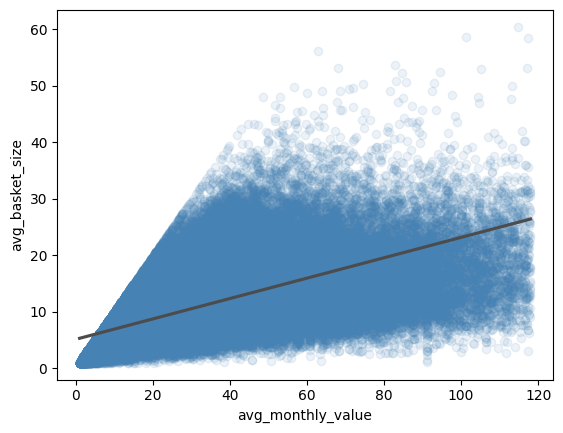

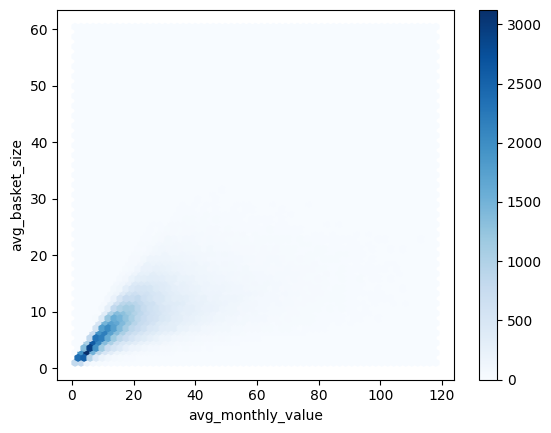

In [36]:
correlation = metrics_trunc['avg_monthly_value'].corr(metrics_trunc['avg_basket_size'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

sns.regplot(
    x="avg_monthly_value",
    y="avg_basket_size",
    data=metrics_trunc,
    scatter_kws={'alpha': 0.1, 'color': 'steelblue'},
    line_kws={'color': '#4C4C4C'} 
)
metrics_trunc.plot.hexbin(
    x="avg_monthly_value",
    y="avg_basket_size",
    gridsize=60,
    cmap="Blues"
)

#### Observed Relationship

Average basket size is strongly correlated with average monthly value (r = 0.64). The scatterplot shows a triangular distribution with a sharp diagonal boundary on the left. This occurs mechanically: for customers with very few lifetime orders, basket size and value both scale directly with total products, producing a near 1:1 relationship.

The heatmap provides a clearer view of the distribution. Most customers fall in the 0–30 range for both variables, and as monthly value increases, the variation in basket size also increases.

#### Interpretation

The positive correlation indicates that larger baskets are generally associated with higher value, but the wide spread again highlights important heterogeneity in customer behavior. Consistent with findings on order frequency:
 - Some high-value customers achieve this through small but frequent baskets.
 - Others reach high value through large baskets, even if they order less often.
 - Very large baskets with low monthly value (e.g. rare but huge orders) are theoretically possible but do not appear in the dataset, suggesting they are extremely uncommon.

This variation further supports multiple customer pathways to value - frequency-driven versus basket-driven - which could warrant different marketing or loyalty strategies.

#### Limitations

Both visualisations have the same drawbacks as for frequency and re-order rate: the scatterplot is too dense at lower values to reveal detail, while the heatmap washes out rare high-value cases. 

Once again, more critically, the absence of unit/spend data limits our interpetation. We cannot distinguish between customers who buy a few expensive items versus a few low cost items, or even many of the same item. This limits our precision in estimating basket size and average value, and thus our ability to link basket size patterns to customer value. 

### Comparisons

The plots all illustrate a very high degree of heterogeneity in the data. There are high and low value customers with diverse order rates, basket sizes, and particualarly re-order rates, for which the correlation is weaker than the other metrics (which are strong correlations). 

The positive associations nevertheless indicate a general, perhaps expected, tendency for customers with larger order frequency, basket, and re-order rate to have larger average monthly value. This suggests these factors may be of interest for marketing and loyalty (e.g. increasing basket size through group promotions, loyalty schemes to encourage regular ordering). 

The comparisons are all limited by the lack of unit, spend and demographic data, in the manner outlined above. 

### 4.3 Super users

We now analyse the top 1% we previously excluded. First, we define and count the users:

In [37]:
metrics_full = (customer_value.merge(metrics, on="user_id", how="inner"))

threshold = customer_value["avg_monthly_value"].quantile(0.99)

super_users = metrics_full[metrics_full["avg_monthly_value"] >= threshold]

regular_users = metrics_full[metrics_full["avg_monthly_value"] < threshold]

print("Super users:", len(super_users))
print("Regular users:", len(regular_users))

Super users: 2063
Regular users: 204140


We compare the super users on our metrics of basket size, reorder rate and orders per month:

In [38]:
# Calculate the mean and standard deviation for super users
super_summary = super_users[["avg_basket_size", "reorder_rate", "orders_per_month"]].agg(['mean', 'std']).T

# Calculate the mean and standard deviation for regular users
regular_summary = regular_users[["avg_basket_size", "reorder_rate", "orders_per_month"]].agg(['mean', 'std']).T

# Combine the results into a single DataFrame for comparison
comparison = pd.DataFrame({
    "Super Users Mean": super_summary['mean'],
    "Super Users Std Dev": super_summary['std'],
    "Regular Users Mean": regular_summary['mean'],
    "Regular Users Std Dev": regular_summary['std']
})

print(comparison)

                  Super Users Mean  Super Users Std Dev  Regular Users Mean  \
avg_basket_size          20.174977             9.053288            9.881762   
reorder_rate              0.589645             0.235365            0.442866   
orders_per_month         10.763105            12.316397            2.820576   

                  Regular Users Std Dev  
avg_basket_size                5.707162  
reorder_rate                   0.205427  
orders_per_month               1.769177  


We see the super users have higher metrics for all categories. The average basket size is around double, the reorder rate is 14% greater, and the frequency is around 3.8* greater on average for the super users. The standard deviations for these metrics, and for each group, vary.

Average basket size:
Although super users have a higher average basket size, their purchasing behavior is less consistent, as shown by a large standard deviation (9.05) compared to the regular users (5.71). Nevertheless, both groups are relavtively heterogeneous with coefficints of variation of around 50%. 

Reorder rates:
The similar standard deviations for reorder rates (0.24 and 0.21) suggest that both groups have a comparable level of predictability in this metric in absolute terms, and demonstrates a large amount of overlap between the groups despite the average difference.

Frequency:
A striking finding is the high standard deviation for orders per month among super users (12.32), which reveals significant variability in their ordering frequency. The behavior of regular users is comparably far more consisent (SD: 1.77) and indicates that the super user group is composed of a diverse mix of ordering patterns. However, it is important to note that the regular users are also a highly heterogeneous group (coefficient of variation of 62.8%, compared with 114.5% for the super users). 

Both groups contain high levels of variation, re-enforcing the earlier findings of great variety of engagement patterns with the service. In order to better understand these engagement patterns, it would be of interest to perform customer segmentation analysis (though demographic and spend data is likely required, in order to differentiate clearly between e.g. different household sizes vs spending behaviour per se)

## 5. Conclusions and Recommendations

### 5.1 Executive Summary
Our analysis revealed that customer value is driven by basket size, order frequency, and reorder rate. However, the high degree of heterogeneity within our customer base indicates that a "one-size-fits-all" approach to marketing and loyalty would be sub-optimal. Our findings highlight the need for a granular understanding of customer behavior to develop targeted strategies.

### 5.2 Key Findings & Limitations
Our analysis established a clear correlation between customer value and key behaviors, but we also identified several limitations that constrain our conclusions:
- Behavioral Indicators: Basket size, order frequency, and reorder rate were found to be strong indicators of customer value.
- Customer Segmentation: We observed significant heterogeneity in customer behavior, suggesting the existence of distinct segments (e.g. high value infrequent orderers (bulk shoppers) vs high value frequent orderers (frequent shoppers)).
- Data Limitations: The lack of unit, spend and demographic data limited the precision of our value metric, basket size metric, and analysis overall. In a real-world analysis, this information would be critical for defining value more accurately and identifying factors like household size.
- Methodological Limitations: This was an exploratory, correlational analysis. Without a regression model, we could not determine the specific explanatory power of each variable or establish causal relationships. We also did not analyze customer behavior over time, which would provide insight into customer lifecycle.

### 5.3 Recommendations & Next Steps
Based on our findings, we recommend the following steps to build on this foundational analysis:
- Enrich the Data: Request and integrate spend, demographic, and geolocational data to refine the customer value metric and build a more comprehensive view of the customer.
- Perform Customer Segmentation: Conduct a cluster analysis to segment the customer base based on their behavior and value. This will enable the creation of highly targeted marketing and loyalty campaigns.
- Build a Predictive Model: Use regression analysis to quantify the explanatory power of key behavioral factors on customer value. This will provide a data-driven basis for future business decisions.
- Conduct Time-Series Analysis: Explore how customer behavior evolves over time, using cohorts to understand changes in engagement, frequency, and value over the customer lifecycle and inform targeted marketing and retention strategies.